In [1]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [2]:
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [3]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

import asyncio
import logging
from datetime import datetime

from langchain.chat_models import init_chat_model


logger = logging.getLogger(__name__)

# Initialize the language model to be used for memory extraction
model = init_chat_model(model="gemini-2.0-flash-lite", model_provider="google_genai")

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

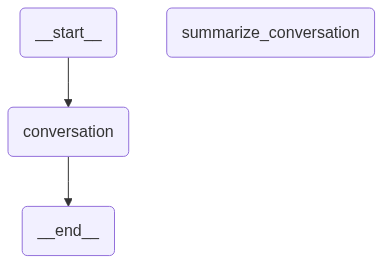

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Lance! 😊
================================== Ai Message ==================================

Awesome! Go 49ers! What do you like most about the team? Are you excited about the upcoming season?


In [7]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='b702c129-3158-4bb5-bc9f-d1ee96b4e739'), AIMessage(content="Hi Lance! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--740f80b6-b7de-440e-ac76-dd55b662c9cb-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='4c96fca4-ee4c-4096-995f-21aa51e39ebd'), AIMessage(content='Your name is Lance! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--7c19d8f6-efdc-48b9-83be-b2415